## Plot results

1289.9920749417668


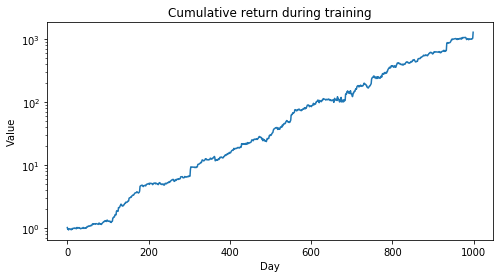

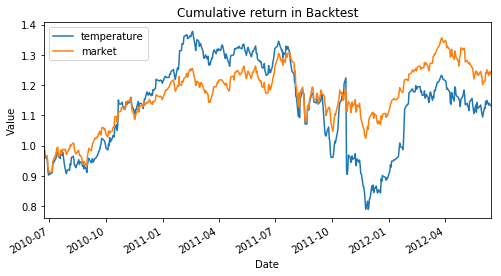

In [14]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from dataset import StockData
data = StockData('data.csv', features=['Open', 'High', 'Low', 'Close'])


def train_plot(save_dir):
    save_dir = Path(save_dir)
    last_epoch = pd.read_csv(save_dir.joinpath('train_last_epoch.csv'))
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Value')
    ax1.set_yscale('log')
    ax1.set_title('Cumulative return during training')
    # cumulative return of the last epoch in training period
    ret = last_epoch['tr_ret']+1
    print(np.prod(ret))
    ax1.plot(ret.cumprod())
    return fig1

def backtest_plot(save_dirs):
    fig2, ax2 = plt.subplots(figsize=(8, 4))
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Value')
    ax2.set_title('Cumulative return in Backtest')
    tmp_dict = {}
    for save_dir in map(Path, save_dirs):
        name = os.path.basename(save_dir)
        test_summary = pd.read_csv(save_dir.joinpath('test_summary.csv'), index_col='index')
        tmp_dict[name] = (test_summary['ret']+1).cumprod().values # Series -> np array, ignore index
    start = test_summary.index[0]
    end = test_summary.index[-1] + 1
    market = data.UBAH(start, end)
    tmp_dict['market'] = market
    df = pd.DataFrame(tmp_dict)
    df.plot(ax=ax2)
    return fig2

def expand_dir(save_dir):
    return [os.path.join(save_dir, sub) for sub in next(os.walk(save_dir))[1]]

save_dir = Path('exp/output/temperature')
fig1 = train_plot(save_dir)
fig2 = backtest_plot([save_dir])


## Case Study
It's necessary to investigate the prediction on a single training/testing point because huge negative return is produced on some days.

### findings

1. output similar to one-hot encoding which means only one stock is held at a time
2. some stocks are much more likely to be chosen
3. a stock with with downtrend is still chosen

,ret
index,
1444,-0.250838
1418,-0.073708
1466,-0.067596
1389,-0.055070
1127,-0.045532
1391,-0.045405
1463,-0.045367
1397,-0.045305
1387,-0.043470


historical closing price:
[[ 0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00 -0.06 -0.06 -0.07 -0.04 -0.06]
 [ 0.00 -0.03 -0.03  0.02  0.05  0.04]
 [ 0.00 -0.05 -0.04 -0.04 -0.03 -0.07]
 [ 0.00 -0.01 -0.01  0.02  0.04  0.02]
 [ 0.00 -0.02 -0.02 -0.01  0.00  0.01]
 [ 0.00 -0.02 -0.01 -0.00  0.01 -0.01]
 [ 0.00  0.04  0.01  0.03  0.05  0.05]
 [ 0.00 -0.01 -0.01 -0.01 -0.00 -0.02]
 [ 0.00 -0.02 -0.00  0.05  0.06 -0.31]
 [ 0.00 -0.00 -0.00 -0.00 -0.00 -0.01]]
price change:
[ 0.00 -0.02 -0.01 -0.04 -0.02  0.00 -0.02  0.00 -0.01 -0.35 -0.00]
network output:
[0.02 0.03 0.06 0.01 0.08 0.02 0.02 0.01 0.03 0.71 0.02]
8
No pattern found!


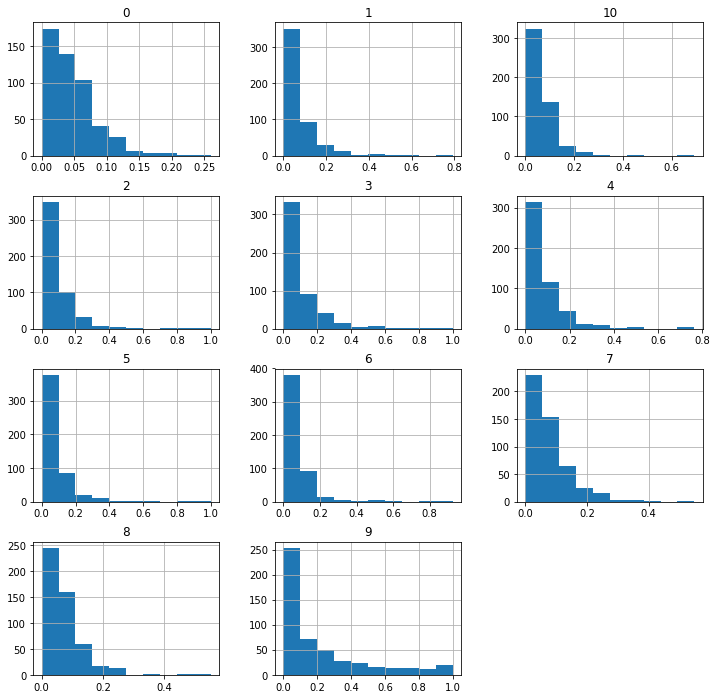

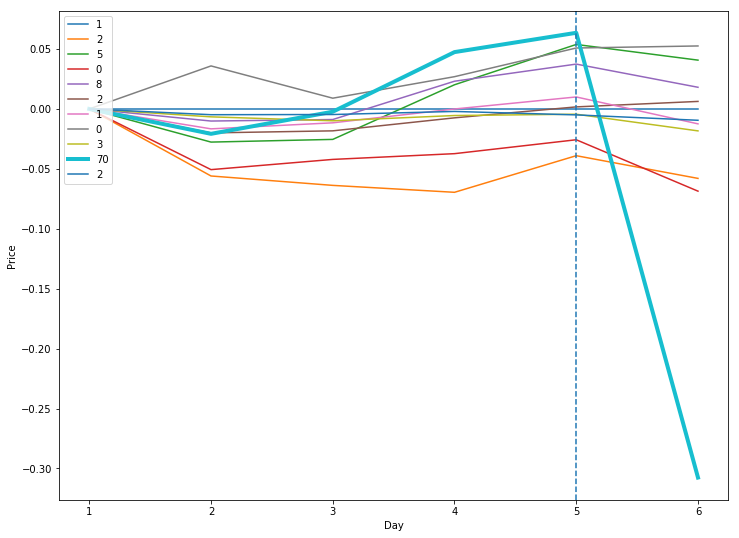

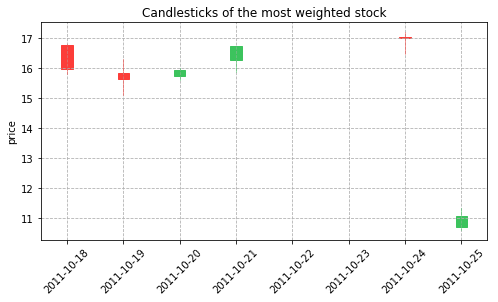

In [16]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from mpl_finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num
import talib
from talib import abstract

idx = pd.IndexSlice
np.set_printoptions(precision=2, suppress=True, floatmode='fixed')



def candle(quotes, title):
    '''plot candlesticks'''
    fig, ax = plt.subplots(figsize=(8, 4))
    candlestick_ohlc(ax, quotes, colorup='#3cc35d', colordown='#fc3d39')
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.set_ylabel('price')
    ax.set_title(title)
    ax.grid(True, linestyle='--')
    for label in ax.xaxis.get_ticklabels():
        label.set_rotation(45)

def pattern(X):
    '''find out what pattern it is'''
    find = False
    X = X.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close'})
    for name in talib.get_function_groups()['Pattern Recognition']:
        f = abstract.Function(name)
        output = f(X)
        if np.any(output):
            find = True
            print('='*20)
            print(name)
            print(output[output!=0])
    if not find:
        print('No pattern found!')

def case(save_dir, k=0):
    # find extreme examples
    top = test_summary.sort_values(by='ret')
    display(top.head(10))
    index = top.index[k]

    # predict
    output = test_output.loc[index].values
    stock_idx = output.argmax()

    # print
    begin = index-data.window
    end = index+1
    X = data._historical_period(begin, end) # 3d, including price on current day
    y = data._price_change(index, end)[0]
    c = data._fi('Close')[0]
    closing = X[c]
    print("historical closing price:\n{}".format(closing))
    print("price change:\n{}".format(y,0))
    print("network output:\n{}".format(output))

    # plot
    # raw output distribution
    asset_num = X.shape[1]
    _ = test_output.hist(figsize=(min(asset_num*4, 12), (asset_num//3+1)*3))

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    df = pd.DataFrame(closing).T
    df.index += 1
    # df.plot(ax=ax3)
    # convert raw output to portfolio weights
    weights = allocate(output)
    for i, c in enumerate(df.columns):
        if i == stock_idx:
            ax.plot(df[c], label='{:d}'.format(int(weights[i]*100)), linewidth=4.0)
        else:
            ax.plot(df[c], label='{:d}'.format(int(weights[i]*100)))
    ax.axvline(df.index[-2], linestyle='--')
    ax.legend(loc='upper left')
    
    # access data_raw directly instead of using X in order to get date and raw price
    if data.cash and stock_idx!=0:
        stock_idx -= 1
    print(stock_idx)
    best_stock = data.stocks[stock_idx]
    OHLC = data.data_raw.iloc[begin:end].loc[:,idx[['Open', 'High', 'Low', 'Close'], best_stock]]
    OHLC.columns = OHLC.columns.droplevel(1)
    OHLC.reset_index(inplace=True)
    OHLC.Date = date2num(OHLC.Date)
    candle(OHLC.values, title='Candlesticks of the most weighted stock')

    pattern(OHLC.iloc[:-1])

# restart the kernel after changing dir
save_dir = Path('exp/output/temperature')
os.environ['CONFIG_LOCAL_DIR'] = str(save_dir)
from config_global import data
from main import allocate
test_summary = pd.read_csv(save_dir.joinpath('test_summary.csv'), index_col='index')
test_output = pd.read_csv(save_dir.joinpath('test_output.csv'), index_col=0)

case(save_dir, 0)